# Trabajo 4: Redes Neuronales

### Integrantes:

- Jackeline Gómez Londoño. CC: 1000413417
- Jorge Alzate. CC: 1192918606

### Instrucciones:

- Modifique el nombre de este archivo con los nombres de los integrantes.
- Agrege los nombres y documentos de identidad de los integrantes del equipo en la sección de arriba.
- Resuelva la situación planteada cumpliendo los criterios de aceptación. Estos criterios son los que determinarán su calificación.
- Entregue:
    - Este notebook con el desarrollo de su ejercicio
    - El modelo ya entrenado en **formato HDF5** (archivo de extensión **`.h5`**). Asignele un nombre aprompiado que contenga las iniciales de los integrantes.

# Problema: Clasificación de Imágenes de Aves


Conjunto de datos de 525 especies de aves. 84635 imágenes de entrenamiento, 2625 imágenes de prueba (5 imágenes por especie) y 2625 imágenes de validación (5 imágenes por especie). Este es un conjunto de datos de muy alta calidad en el que solo hay un ave en cada imagen y el ave generalmente ocupa al menos el 50% de los píxeles en la imagen.

Se desea realizar una red neuronal que permita clasificar estas 525 especies de aves y para ello, utilice la técnica de Transferencia de Aprendizaje (Transfer Learning) para utilizar una red previamente entrenada y desarrollar un nuevo modelo.

Descargue las imágenes en [este link](https://udemedellin-my.sharepoint.com/:u:/g/personal/jjospina_udemedellin_edu_co/ERSosEmX8jFEnr1Y-C9-AYsBArLCpW9ItsXpWWC5f_RWpg?e=dPHsix).
        
Las categorías de cada imagen se encuentran según la carpeta donde estén alojadas.

## Ponderación de la calificación

- **(50%)** Entrenamiento del modelo:
    - Elija un modelo de red neuronal pre-entrenado para utilizarlo en la solución del problema. Algunas fuentes para buscar modelos son:
        - Aplicaciones ofrecidas por [Keras](https://keras.io/api/applications/)
        - [TensorFlow Hub](https://tfhub.dev/)
        - [Nvidia NGC](https://catalog.ngc.nvidia.com/?filters=&orderBy=weightPopularASC&query=)
    - Congele el modelo base
    - Agregue nuevas capas a su modelo para adaptarlo al problema
    - Haga un proceso de ***Data Augmentation***
    - Compile y entrene su modelo
    - Realice ***Fine-Tuning***
    - Calcule la precisión de su modelo   
- **(50%)** Validación del modelo. Se han reservado 2625 imágenes para probar que tan bueno es el modelo. **NO DEBE ENTRENAR SU MODELO CON ESTAS IMÁGENES**. Harán el papel de "nuevas imágenes" que ingresan a un modelo ya entrenado. Con estas imágenes se calculará la precisión de la red. El score mínimo será del 60%. La nota de este item será de acuerdo al ranking de los mejores modelos del curso.

## Modelo pre-entrenado

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
from tensorflow import keras
base_model = tf.keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False
)

In [4]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Congelar el modelo base

In [5]:
base_model.trainable = False

## Agregar nuevas capas


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2D,MaxPooling2D

# Agregar capas personalizadas a la red
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(525, activation='softmax')(x)  # Ajusta num_classes según tus necesidades

# Combinar el modelo base con las nuevas capas
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Compilar el modelo

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Aumentando los datos

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

In [10]:
datagen_train = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

datagen_test = ImageDataGenerator(samplewise_center=True)

## Cargando los datos

In [11]:
train_it = datagen_train.flow_from_directory(
    "birds/train/",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=45,
)

test_it = datagen_test.flow_from_directory(
    "birds/test/",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=45,
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


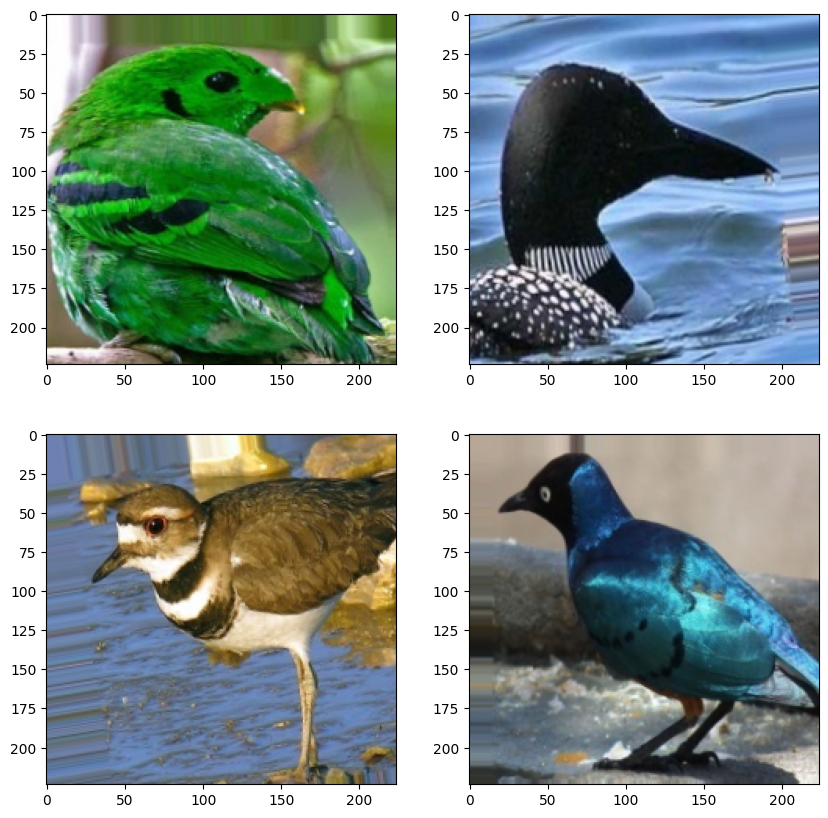

In [12]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 4
x, y = train_it.next()
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(image/255)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


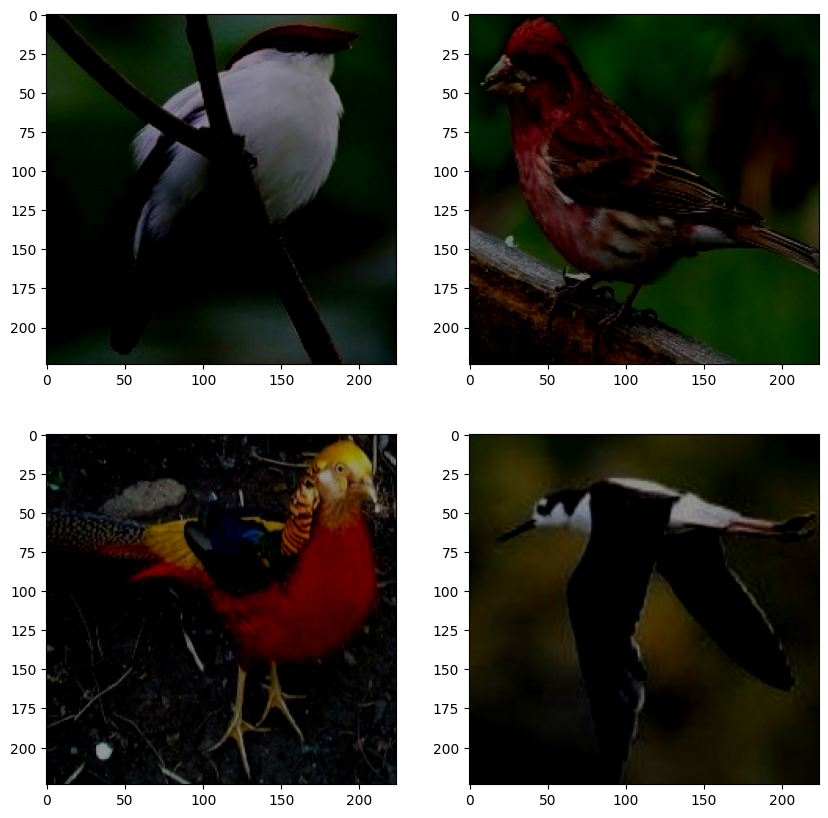

In [13]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 4
x, y = test_it.next()
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(image/255)
plt.show()

## Entrenar modelo

In [14]:
model.fit(train_it, validation_data=test_it, epochs=15, steps_per_epoch=1880)

Epoch 1/15
1880/1880 [==============================] - 473s 248ms/step - loss: 2.4741 - accuracy: 0.4575 - val_loss: 1.2622 - val_accuracy: 0.6754
Epoch 2/15
1880/1880 [==============================] - 459s 244ms/step - loss: 1.3814 - accuracy: 0.6528 - val_loss: 1.0812 - val_accuracy: 0.7250
Epoch 3/15
1880/1880 [==============================] - 461s 245ms/step - loss: 1.2125 - accuracy: 0.6926 - val_loss: 0.9539 - val_accuracy: 0.7482
Epoch 4/15
1880/1880 [==============================] - 459s 244ms/step - loss: 1.1263 - accuracy: 0.7128 - val_loss: 0.9925 - val_accuracy: 0.7497
Epoch 5/15
1880/1880 [==============================] - 461s 245ms/step - loss: 1.0844 - accuracy: 0.7218 - val_loss: 0.9883 - val_accuracy: 0.7749
Epoch 6/15
1880/1880 [==============================] - 461s 245ms/step - loss: 1.0402 - accuracy: 0.7336 - val_loss: 1.0493 - val_accuracy: 0.7531
Epoch 7/15
1880/1880 [==============================] - 460s 244ms/step - loss: 1.0186 - accuracy: 0.7414 - val_

## Fine-Tuning

In [16]:
from tensorflow.keras.optimizers import SGD

for layer in model.layers[:15]:
    layer.trainable = False
for layer in model.layers[15:]:
    layer.trainable = True

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])

model.fit(train_it, validation_data=test_it, epochs=15, steps_per_epoch=1880)

C:\Users\mario\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15
1880/1880 [==============================] - 461s 245ms/step - loss: 0.5932 - accuracy: 0.8382 - val_loss: 0.7365 - val_accuracy: 0.8328
Epoch 2/15
1880/1880 [==============================] - 459s 244ms/step - loss: 0.3821 - accuracy: 0.8922 - val_loss: 0.5394 - val_accuracy: 0.8682
Epoch 3/15
1880/1880 [==============================] - 459s 244ms/step - loss: 0.3000 - accuracy: 0.9133 - val_loss: 0.5850 - val_accuracy: 0.8560
Epoch 4/15
1880/1880 [==============================] - 459s 244ms/step - loss: 0.2492 - accuracy: 0.9268 - val_loss: 0.5299 - val_accuracy: 0.8655
Epoch 5/15
1880/1880 [==============================] - 459s 244ms/step - loss: 0.2163 - accuracy: 0.9345 - val_loss: 0.5128 - val_accuracy: 0.8750
Epoch 6/15
1880/1880 [==============================] - 460s 244ms/step - loss: 0.1889 - accuracy: 0.9425 - val_loss: 0.4810 - val_accuracy: 0.8819
Epoch 7/15
1880/1880 [==============================] - 460s 245ms/step - loss: 0.1640 - accuracy: 0.9507 - val_

In [17]:
datagen_valid = ImageDataGenerator(samplewise_center=True)

valid_it = datagen_valid.flow_from_directory(
    'birds/valid/',
    target_size=(224, 224),
    batch_size=45,
    class_mode='categorical'
)

results = model.evaluate(valid_it)
accuracy = results[1] * 100
print(f'Precisión del modelo en el conjunto de prueba: {accuracy:.2f}%')

Found 2625 images belonging to 525 classes.
59/59 [==============================] - 9s 150ms/step - loss: 0.6822 - accuracy: 0.8819
Precisión del modelo en el conjunto de prueba: 88.19%


In [18]:
model.save('jorgeAlzate_jackelineGomez.h5')